# Importing All The Required Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import shutil
import keras
import tensorflow as tf
from glob import glob
from PIL import Image
from keras import layers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,GlobalAveragePooling2D,Dropout,Input
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.models import Sequential,Model
from keras import backend as K
from IPython.display import display
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import ReduceLROnPlateau

Loading of Data from Ham10000.csv file into skin_df2 dataframe

In [2]:
skin_df2 = pd.read_csv('E:/DataVisualisation/Coursework/Machine_Learning/HAM10000.csv')

In [3]:
print(skin_df2.head())


       image_id                       cell_type  is_benign localization
0  ISIC_0027419  Benign keratosis-like lesions         1.0        scalp
1  ISIC_0026769  Benign keratosis-like lesions         1.0        scalp
2  ISIC_0031633  Benign keratosis-like lesions         1.0          ear
3  ISIC_0029176  Benign keratosis-like lesions         1.0         face
4  ISIC_0029068  Benign keratosis-like lesions         1.0         face


# Data PreProcessing

**Removing column localization as it is not used for training**

In [4]:
skin_df2=skin_df2.drop('localization',1)


In [5]:
skin_df2

,image_id,cell_type,is_benign
0,ISIC_0027419,Benign keratosis-like lesions,1.0
1,ISIC_0026769,Benign keratosis-like lesions,1.0
2,ISIC_0031633,Benign keratosis-like lesions,1.0
3,ISIC_0029176,Benign keratosis-like lesions,1.0
4,ISIC_0029068,Benign keratosis-like lesions,1.0
...,...,...,...
5367,ISIC_0027265,Benign keratosis-like lesions,1.0
5368,ISIC_0025029,Melanocytic nevi,1.0
5369,ISIC_0029462,Melanocytic nevi,1.0
5370,ISIC_0030510,Melanocytic nevi,1.0


**Displaying all types of values present in cell_type column.**

In [6]:
print(skin_df2['cell_type'].unique())

['Benign keratosis-like lesions ' 'Dermatofibroma' 'Melanoma'
 'Vascular lesions' 'Basal cell carcinoma' 'Melanocytic nevi'
 'Actinic keratoses' nan]


**As from the result of above code we  found "nan" value in the column which depict that coloumn "cell_type " has null value present in it**

In [7]:
print(skin_df2['is_benign'].unique())

[ 1.  0. nan]


**As from the result of above code we  found "nan" value in the column which depict that coloumn "is_benign" has null value present in it**

In [8]:
print(skin_df2['image_id'].isnull().any())

False


**Output of the above code depicts that column "image_id" does not have any null value in it.**

In [9]:
print(skin_df2['is_benign'].isna().any())

True


In [10]:
print(skin_df2['cell_type'].isna().any())

True


**Droping all the rows that has "null values" in it and storing the resultant dataframe as skin_df2**

In [11]:
skin_df2=skin_df2.dropna()

### Exploratory Data Analysis

**Changing data type of column "is_benign" from float to integer value and display of Resultant dataframe "skin_df2".**

In [12]:
skin_df2['is_benign']=skin_df2['is_benign'].astype('int')
skin_df2

,image_id,cell_type,is_benign
0,ISIC_0027419,Benign keratosis-like lesions,1
1,ISIC_0026769,Benign keratosis-like lesions,1
2,ISIC_0031633,Benign keratosis-like lesions,1
3,ISIC_0029176,Benign keratosis-like lesions,1
4,ISIC_0029068,Benign keratosis-like lesions,1
...,...,...,...
5367,ISIC_0027265,Benign keratosis-like lesions,1
5368,ISIC_0025029,Melanocytic nevi,1
5369,ISIC_0029462,Melanocytic nevi,1
5370,ISIC_0030510,Melanocytic nevi,1


### Label Encoding

**Label encoding of column "cell_type" from text value to string value.**

In [13]:
np.random.seed(42)

**Initialise the LabelEncoder as "le".**

In [14]:
le = LabelEncoder()

**Fit the label encoder to column 'cell_type' of dataframe "skin_df2" and also print the label.**

In [15]:
le.fit(skin_df2['cell_type'])
print(list(le.classes_))

['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions ', 'Dermatofibroma', 'Melanocytic nevi', 'Melanoma', 'Vascular lesions']


**Here label is transformed  into numeric value and stored in new column named label in "skin_df2" dataframe.**

In [16]:
skin_df2['label'] = le.transform(skin_df2["cell_type"]) 
print(skin_df2.sample(10))

          image_id                       cell_type  is_benign  label
8     ISIC_0025915  Benign keratosis-like lesions           1      2
4758  ISIC_0032523                Melanocytic nevi          1      4
3809  ISIC_0033698                Melanocytic nevi          1      4
5199  ISIC_0025661                Melanocytic nevi          1      4
4151  ISIC_0030135                Melanocytic nevi          1      4
2851  ISIC_0030331                Melanocytic nevi          1      4
2670  ISIC_0025496                Melanocytic nevi          1      4
1215  ISIC_0028431                Vascular lesions          1      6
1025  ISIC_0027900                        Melanoma          0      5
1094  ISIC_0025832                        Melanoma          0      5


### Visualisation of the provided Data

**Given below graph represent the data distribution of seven categories of coloumn "cell_type".Graphs shows that the  dataset  is not balanced as 'Melanocytic nevi' has very large no of volume (3527) as compared to other classes  and also 'Dermatofibroma'(61) and 'Vascular lesions' (71) is very less  as compared to class 'Melanocytic nevi' and other classes.**

4    3527
5     585
2     580
1     273
0     175
6      71
3      61
Name: label, dtype: int64


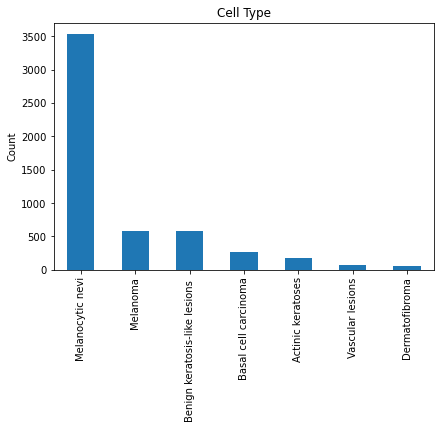

In [17]:
graph = plt.figure(figsize=(15,10))
axis1 = graph.add_subplot(221)
skin_df2['cell_type'].value_counts().plot(kind='bar', ax=axis1)
axis1.set_ylabel('Count')
axis1.set_title('Cell Type');
print(skin_df2['label'].value_counts())

**Given below graph shows that benign (4242)is comparatively more than maligant(1030), so this shows that here dataset is not balanced according to classes of  "is_benign" column.**

1    4242
0    1030
Name: is_benign, dtype: int64


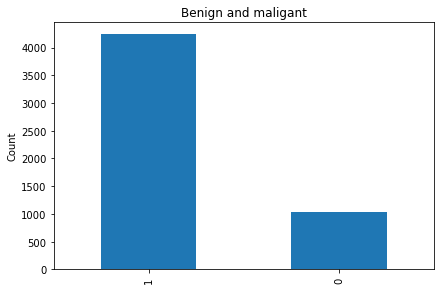

In [18]:
graph = plt.figure(figsize=(15,10))
axis1 = graph.add_subplot(221)
skin_df2['is_benign'].value_counts().plot(kind='bar', ax=axis1)
axis1.set_ylabel('Count')
axis1.set_title('Benign and maligant');
print(skin_df2['is_benign'].value_counts())

## Balancing Data

### Balancing data according to class of coloumn 'label'.

**Here we are first separating each class values into a seperate dataset. This will help us to augment them indvidually.**

In [19]:
df_0 = skin_df2[skin_df2['label'] == 0]
df_1 = skin_df2[skin_df2['label'] == 1]
df_2 = skin_df2[skin_df2['label'] == 2]
df_3 = skin_df2[skin_df2['label'] == 3]
df_4 = skin_df2[skin_df2['label'] == 4]
df_5 = skin_df2[skin_df2['label'] == 5]
df_6 = skin_df2[skin_df2['label'] == 6]

**Now next step is to resample it. Here as we know that classes are not distributed equally so we are resampling it. Here we are using "resample" from "sklearn.utils".This will resample datas of each classes, As we are choosing resampling data as 250 ,so it will upscale data of classes which has lesser count of data than 250 and also it will bring down the data of classes which has count of data more than 250.** 

In [20]:
n_samples=250
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)


**Now here we are combining all the balanced dataset of all 7 classes into one single dataframe. As below displayed count of data of each class shows that the dataframe "skin_df_balanced" is balanced.**

In [21]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])
print(skin_df_balanced['label'].value_counts())

0    250
1    250
2    250
3    250
4    250
5    250
6    250
Name: label, dtype: int64


**Similary here we are balancing dataset according to classes of column 'is_benign'.**

**separating  2 classes into two seperate dataset.**

In [22]:
df_0 = skin_df2[skin_df2['is_benign'] == 0]
df_1 = skin_df2[skin_df2['is_benign'] == 1]

**Resampling  each dataset into 2500.**

In [23]:
n_samples=2500
df_0_balanced2 = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced2 = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 

**Combining both dataset into a single dataset.**

In [24]:
skin_df_balanced2 = pd.concat([df_0_balanced2, df_1_balanced2])
print(skin_df_balanced2['is_benign'].value_counts())

0    2500
1    2500
Name: is_benign, dtype: int64


  **The given code below will  will extract the path of all image with .jpeg extension present in the ham_data folder and store it in a dictonary  with image name as key and path of image as value.**

In [25]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('ham_data/', '*.jpg'))}

**Adding a new column named path and adding path of each image with respect to values in "image_id" coulumn.**

In [26]:
skin_df_balanced['path'] = skin_df2['image_id'].map(image_path.get)

In [27]:
skin_df_balanced.head()

,image_id,cell_type,is_benign,label,path
4945,ISIC_0027447,Actinic keratoses,0,0,ham_data\ISIC_0027447.jpg
4935,ISIC_0026525,Actinic keratoses,0,0,ham_data\ISIC_0026525.jpg
4857,ISIC_0028381,Actinic keratoses,0,0,ham_data\ISIC_0028381.jpg
4949,ISIC_0024923,Actinic keratoses,0,0,ham_data\ISIC_0024923.jpg
4914,ISIC_0029610,Actinic keratoses,0,0,ham_data\ISIC_0029610.jpg


## Data Augumentation

**Here each image opened from the path provided in the present in the "skin_df_balanced" dataset with respect to each image_id .Then each image is resized to (32*32) size and then each image is converted into numpy array and add it to a newly created column named image with respect to each image_id.** 

In [28]:
SIZE=32
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE)))) 


In [29]:
#skin_df_balanced.to_csv('FinalBalancedDataset.csv')

**Plotting the Image which is stored in image coloumn according to the category . Two image is plotted from each category of "cell_type".**

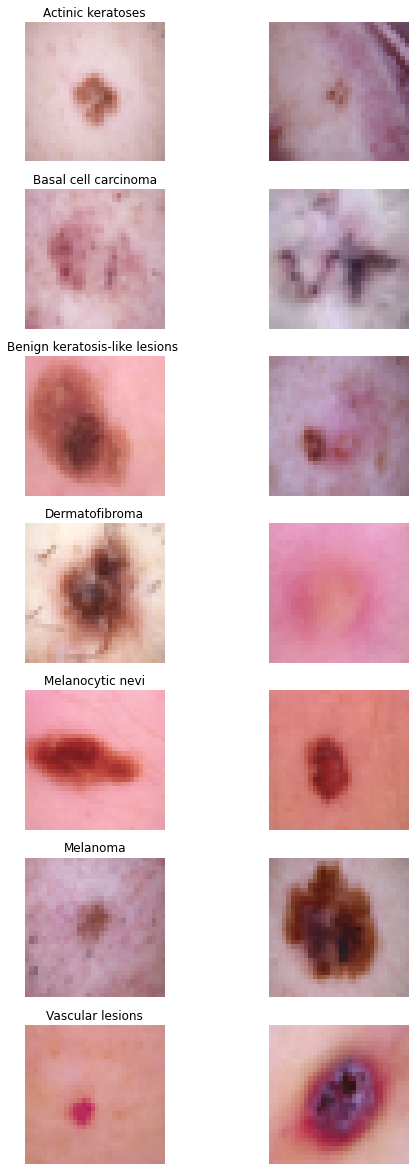

In [30]:
n_samples = 2 
# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,skin_df_balanced.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')


**So here we are considering two coloumn in the dataframe i.e image column and label coulumn.As image column is trained to predict the label.
So X is to store image column values and Y to store assigned label values to that image and X is trained to predict Y.**

**The stored value of image is stored in the from of pixel in image column dataframe .So it will be in the range of  0 to 255 as  minimim pixel value is zero and maximum is 255. So in the below code we are normalising it to the scale of 0-1 by dividing by 255.**

**Step 1:Converting value of image coloumn into numpy array and storing it as a list 'X'.**

In [31]:
X = np.asarray(skin_df_balanced['image'].tolist())

**Step 2:Scaling the value of all images in the list to 0-1 by dividing by 255.**

In [32]:
X = X/255.

**Step 3:Assigning  label values to Y**

In [33]:
Y=skin_df_balanced['label'] 

**Step 4:As this is a multiclass classification So we have to change Y to categorical format.**

In [34]:
Y_cat = to_categorical(Y, num_classes=7) 

## Spliting To Training and Testing Data

In [73]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

## Defining The Model

**The model was suggested by autokeras which was best for the given dataset** 

In [70]:
num_classes = 7

model1 = Sequential()
model1.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
model1.add(MaxPool2D(pool_size=(2, 2)))  
model1.add(Dropout(0.3))

model1.add(Conv2D(128, (3, 3),activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))  
model1.add(Dropout(0.3))

model1.add(Conv2D(64, (3, 3),activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))  
model1.add(Dropout(0.3))
model1.add(Flatten())

model1.add(Dense(32))
model1.add(Dense(7, activation='softmax'))
model1.summary()

model1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_212 (Conv2D)         (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 15, 15, 256)      0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 15, 15, 256)       0         
                                                                 
 conv2d_213 (Conv2D)         (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 6, 6, 128)        

In [71]:

batch_size = 16 
epochs = 50

checkpoint_path = "Model_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


**Create a callback that saves the model's weights**

In [72]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model1.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2,callbacks=[cp_callback])
model1.save('Model_1/my_model1.h5')


Epoch 1/50

Epoch 1: saving model to Model_1\cp.ckpt
108/108 - 12s - loss: 1.9414 - acc: 0.1691 - val_loss: 1.8913 - val_acc: 0.2286 - 12s/epoch - 114ms/step
Epoch 2/50

Epoch 2: saving model to Model_1\cp.ckpt
108/108 - 12s - loss: 1.8205 - acc: 0.2274 - val_loss: 1.8102 - val_acc: 0.2571 - 12s/epoch - 113ms/step
Epoch 3/50

Epoch 3: saving model to Model_1\cp.ckpt
108/108 - 12s - loss: 1.7321 - acc: 0.2851 - val_loss: 1.6860 - val_acc: 0.4286 - 12s/epoch - 113ms/step
Epoch 4/50

Epoch 4: saving model to Model_1\cp.ckpt
108/108 - 13s - loss: 1.5782 - acc: 0.3475 - val_loss: 1.4295 - val_acc: 0.4000 - 13s/epoch - 117ms/step
Epoch 5/50

Epoch 5: saving model to Model_1\cp.ckpt
108/108 - 14s - loss: 1.4606 - acc: 0.3930 - val_loss: 1.3133 - val_acc: 0.4571 - 14s/epoch - 128ms/step
Epoch 6/50

Epoch 6: saving model to Model_1\cp.ckpt
108/108 - 14s - loss: 1.4090 - acc: 0.4332 - val_loss: 1.2484 - val_acc: 0.5143 - 14s/epoch - 126ms/step
Epoch 7/50

Epoch 7: saving model to Model_1\cp.ckpt

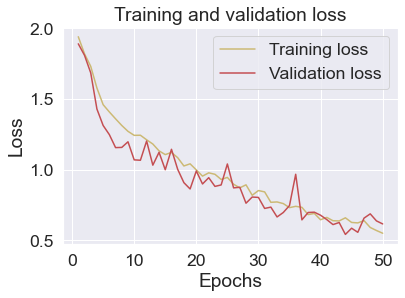

In [80]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

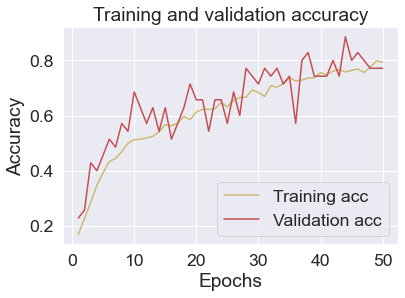

In [81]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [78]:
# Prediction of test dataset
y_pred = model1.predict(x_test)
# Convertion of  predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convertion of  test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

<AxesSubplot:>

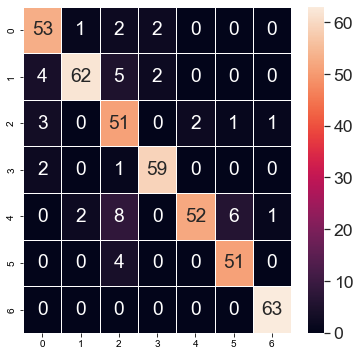

In [79]:
#Printing of confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [75]:
loaded_model = tf.keras.models.load_model('Model_1/my_model1.h5')

In [76]:
score = loaded_model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

14/14 [==============================] - 1s 60ms/step - loss: 0.3633 - acc: 0.8927
Test accuracy: 0.8926940560340881


## Feature -2 Prediction of Benign and Maligant

**Step 1:Converting value of image coloumn into numpy array and storing it as a list 'X'.**

In [154]:
X = np.asarray(skin_df_balanced['image'].tolist())

**Step 2:Scaling the value of all images in the list to 0-1 by dividing by 255.**

In [155]:
X = X/255.

**Step 3:Assigning label values to Y**

In [156]:
Y_cat=skin_df_balanced['is_benign'] 

**Step 4:Splitting of test dataset**

In [157]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

## Definig the neural Model

In [158]:
num_classes = 2

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1424 (Conv2D)        (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 15, 15, 256)      0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 15, 15, 256)       0         
                                                                 
 conv2d_1425 (Conv2D)        (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 6, 6, 128)        

**Initialising batch size as 16 and epochs as 50**

In [159]:

batch_size = 16 
epochs = 50

checkpoint_path = "Model_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

**Creating a callback directory and training model against dataset using testing data set x_test and y_test and training dataset x_train and y_train**

In [160]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2,callbacks=[cp_callback])
model.save('Model_2/my_model1.h5')
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/50

Epoch 1: saving model to Model_2\cp.ckpt
82/82 - 11s - loss: 0.6935 - acc: 0.5579 - val_loss: 0.6885 - val_acc: 0.5753 - 11s/epoch - 135ms/step
Epoch 2/50

Epoch 2: saving model to Model_2\cp.ckpt
82/82 - 11s - loss: 0.6814 - acc: 0.5686 - val_loss: 0.6647 - val_acc: 0.5753 - 11s/epoch - 138ms/step
Epoch 3/50

Epoch 3: saving model to Model_2\cp.ckpt
82/82 - 11s - loss: 0.6710 - acc: 0.5655 - val_loss: 0.6395 - val_acc: 0.5753 - 11s/epoch - 135ms/step
Epoch 4/50

Epoch 4: saving model to Model_2\cp.ckpt
82/82 - 12s - loss: 0.6579 - acc: 0.5633 - val_loss: 0.6158 - val_acc: 0.5799 - 12s/epoch - 145ms/step
Epoch 5/50

Epoch 5: saving model to Model_2\cp.ckpt
82/82 - 12s - loss: 0.6508 - acc: 0.5678 - val_loss: 0.6227 - val_acc: 0.5776 - 12s/epoch - 149ms/step
Epoch 6/50

Epoch 6: saving model to Model_2\cp.ckpt
82/82 - 12s - loss: 0.6443 - acc: 0.5694 - val_loss: 0.6347 - val_acc: 0.6256 - 12s/epoch - 148ms/step
Epoch 7/50

Epoch 7: saving model to Model_2\cp.ckpt
82/82 - 15s

**graph showing training loss and validation loss**

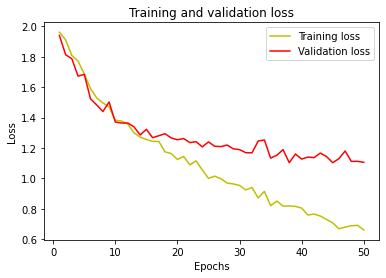

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Graph showing training accuracy vs validation accuracy**

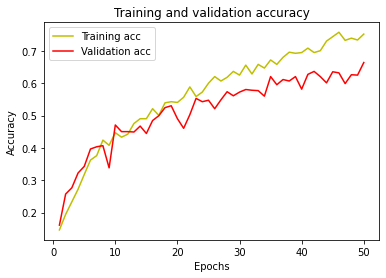

In [46]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Method 2

## Using Pre trained model

## Prediction of Benign

**Here model is trained by images against is_benign coloumn of balanced dataset**

In [110]:
X = np.asarray(skin_df_balanced['image'].tolist())

**Spliting of dataset for testing and traing with 10% for testing**

In [111]:
X = X/255
Y_cat=skin_df_balanced['is_benign'] 
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.10, random_state=42)

In [112]:
X_train.shape, X_val.shape


((1662, 32, 32, 3), (88, 32, 32, 3))

In [113]:
y_train.shape, y_val.shape

((1575,), (88, 7, 2))

**defining InceptionResNetV2 pretrained model**

In [114]:
pre_trained_model = InceptionResNetV2(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

In [84]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_5
conv2d_815
batch_normalization_812
activation_812
conv2d_816
batch_normalization_813
activation_813
conv2d_817
batch_normalization_814
activation_814
max_pooling2d_19
conv2d_818
batch_normalization_815
activation_815
conv2d_819
batch_normalization_816
activation_816
max_pooling2d_20
conv2d_823
batch_normalization_820
activation_820
conv2d_821
conv2d_824
batch_normalization_818
batch_normalization_821
activation_818
activation_821
average_pooling2d_4
conv2d_820
conv2d_822
conv2d_825
conv2d_826
batch_normalization_817
batch_normalization_819
batch_normalization_822
batch_normalization_823
activation_817
activation_819
activation_822
activation_823
mixed_5b
conv2d_830
batch_normalization_827
activation_827
conv2d_828
conv2d_831
batch_normalization_825
batch_normalization_828
activation_825
activation_828
conv2d_827
conv2d_829
conv2d_832
batch_normalization_824
batch_normalization_826
batch_normalization_829
activation_824
activation_826
activation_829
block35_1_mixed
block35_1_con

In [85]:
last_layer = pre_trained_model.get_layer('conv_7b_ac')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 4, 6, 1536)


## Training of Model

In [94]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='sigmoid')(x)

# Configure and compile the model

modell = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
modell.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [95]:
modell.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1018 (Conv2D)           (None, 95, 127, 32)  864         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_1015 (Batc  (None, 95, 127, 32)  96         ['conv2d_1018[0][0]']            
 hNormalization)                                                                                  
                                                                                            

## Image Augmentation

In [96]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(x_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(x_test)

**Model is trainded against the dataset**

In [162]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=1)
tf.config.experimental_run_functions_eagerly(True)
batch_size = 64
epochs = 3
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2,callbacks=[learning_rate_reduction])


Epoch 1/3
21/21 - 9s - loss: 0.3257 - acc: 0.8476 - val_loss: 0.4972 - val_acc: 0.7511 - lr: 0.0010 - 9s/epoch - 452ms/step
Epoch 2/3
21/21 - 11s - loss: 0.3248 - acc: 0.8399 - val_loss: 0.4866 - val_acc: 0.7694 - lr: 0.0010 - 11s/epoch - 524ms/step
Epoch 3/3
21/21 - 10s - loss: 0.3246 - acc: 0.8392 - val_loss: 0.4845 - val_acc: 0.7603 - lr: 0.0010 - 10s/epoch - 461ms/step


**Compiling the model**

In [64]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

**Validation Accuracy is 76.02% and loss is 48.44%**

In [164]:
loss_val, acc_val = model.evaluate(x_test, y_test, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

14/14 [==============================] - 1s 64ms/step - loss: 0.4845 - acc: 0.7603
Validation: accuracy = 0.760274  ;  loss_v = 0.484464


**Test acuuracy is 77.9 % and loss is 44.56 %**

In [167]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.30, random_state=42)

loss_test, acc_test = model.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

17/17 [==============================] - 1s 65ms/step - loss: 0.4456 - acc: 0.7790
Test: accuracy = 0.779048  ;  loss = 0.445624


## Data visualisation 

Text(0.5, 1.0, 'Training and validation loss')

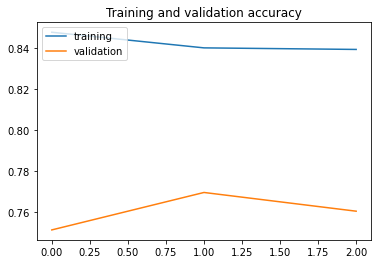

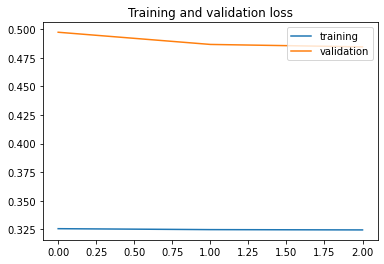

In [168]:
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

## Classification into 7 Categories

**Splitting of data set into testing and training Dataset**

In [169]:
X = np.asarray(skin_df_balanced['image'].tolist())

In [170]:
X = X/255.

In [171]:
Y=skin_df_balanced['label'] 

In [172]:
Y_cat = to_categorical(Y, num_classes=7) 

In [173]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

**Defining Neural Network InceptionResNetV2**

In [41]:
pre_trained_model = InceptionResNetV2(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

In [42]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_1
conv2d_6
batch_normalization
activation
conv2d_7
batch_normalization_1
activation_1
conv2d_8
batch_normalization_2
activation_2
max_pooling2d_6
conv2d_9
batch_normalization_3
activation_3
conv2d_10
batch_normalization_4
activation_4
max_pooling2d_7
conv2d_14
batch_normalization_8
activation_8
conv2d_12
conv2d_15
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_11
conv2d_13
conv2d_16
conv2d_17
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed_5b
conv2d_21
batch_normalization_15
activation_15
conv2d_19
conv2d_22
batch_normalization_13
batch_normalization_16
activation_13
activation_16
conv2d_18
conv2d_20
conv2d_23
batch_normalization_12
batch_normalization_14
batch_normalization_17
activation_12
activation_14
activation_17
block35_1_mixed
block35_1_conv
block35_1
block35_1_ac
conv2d_27
batch_normalization_21
activation_21
conv2d_25
conv

In [43]:
last_layer = pre_trained_model.get_layer('conv_7b_ac')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 4, 6, 1536)


In [52]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='sigmoid')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
modell.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [53]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 95, 127, 32)  864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 127, 32)  96         ['conv2d_6[0][0]']               
 alization)                                                                                       
                                                                                            

In [46]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(x_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(x_test)

In [49]:
tf.config.experimental_run_functions_eagerly(True)
batch_size = 64
epochs = 3
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/3
26/26 - 11s - loss: 0.5780 - acc: 0.7798 - val_loss: 0.5405 - val_acc: 0.7500 - 11s/epoch - 415ms/step
Epoch 2/3
26/26 - 12s - loss: 0.5399 - acc: 0.7966 - val_loss: 0.5561 - val_acc: 0.7841 - 12s/epoch - 443ms/step
Epoch 3/3
26/26 - 12s - loss: 0.5133 - acc: 0.8129 - val_loss: 0.5531 - val_acc: 0.7614 - 12s/epoch - 461ms/step


**Compiling the model**

In [54]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [57]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

**Validation accuracy is 76.13% and loss is 55.31%**

In [60]:
loss_val, acc_val = model1.evaluate(x_test, y_test, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

3/3 [==============================] - 0s 56ms/step - loss: 0.5531 - acc: 0.7614
Validation: accuracy = 0.761364  ;  loss_v = 0.553131


**Training acuuracy is 88.58 % and loss is 37.04%**

In [63]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

loss_test, acc_test = model1.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))


14/14 [==============================] - 1s 62ms/step - loss: 0.3705 - acc: 0.8858
Test: accuracy = 0.885845  ;  loss = 0.370491


Text(0.5, 1.0, 'Training and validation loss')

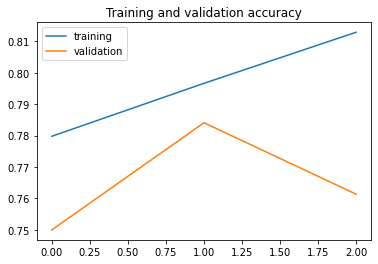

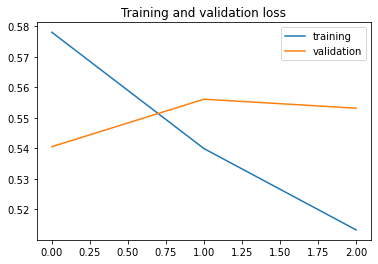

In [64]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')